In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification, pipeline
from sklearn.metrics import confusion_matrix, classification_report
from peft import LoraConfig, TaskType, get_peft_model
from datasets import Dataset
import plotly.graph_objects as go
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import evaluate
import torch
import json
import re

In [2]:
def process_jsonl(input_file, tokenizer, sentiment_mapping):

    def clean_word(word):
        return word.strip()

    def split_text_into_tokens(text):
        return re.findall(r'\w+|[^\w\s]', text, re.UNICODE)

    with open(input_file, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]

    processed_data = []

    for item in data:
        text = item['text']
        labels = item.get('label', [])

        tokens = split_text_into_tokens(text)
        token_offsets = []
        current_pos = 0

        for token in tokens:
            start = text.find(token, current_pos)
            end = start + len(token)
            token_offsets.append((start, end))
            current_pos = end

        token_labels = ["O"] * len(tokens)

        for start, end, sentiment in labels:
            sentiment_standard = sentiment_mapping.get(sentiment, "O")
            if sentiment_standard == "O":
                continue

            for i, (token_start, token_end) in enumerate(token_offsets):
                if token_start >= start and token_end <= end:
                    if token_start == start:
                        token_labels[i] = f"B-{sentiment_standard}"
                    else:
                        token_labels[i] = f"I-{sentiment_standard}"

        cleaned_tokens = [clean_word(token) for token in tokens]
        cleaned_tokens, token_labels = zip(*[
            (token, label) for token, label in zip(cleaned_tokens, token_labels) if token
        ])

        processed_data.append({
            "tokens": list(cleaned_tokens),
            "labels": list(token_labels)
        })

    return processed_data


tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased", use_fast=True)
sentiment_mapping = {
    'Negative': 'Negative',
    'Neutral': 'Neutral',
    'Positive': 'Positive'
}
processed_data = process_jsonl("patryk.jsonl", tokenizer, sentiment_mapping)

In [3]:
dataset = Dataset.from_pandas(pd.DataFrame(processed_data))
print("Dataset example:")
print(dataset[0])

Dataset example:
{'tokens': ['Lakier', 'roweru', 'bardzo', 'kiepskiej', 'jakości', ',', 'robią', 'się', 'odpryski', 'nie', 'wiadomo', 'od', 'czego', 'rower', 'ładny', 'wygodny', 'ale', 'po', '3', 'miesiącach', 'użytkowania', 'widoczne', 'odpryski', 'lakieru', 'czego', 'za', 'taką', 'cenę', 'nie', 'powinno', 'być', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', 'Oczywiście', 'producent', 'twierdzi', 'że', 'są', 'to', 'wady', 'mechaniczne', ',', 'dziecko', 'ma', 'w', 'lepszym', 'stanie', 'lakier', 'na', 'rowerze', 'ale', 'nie', 'z', 'tej', 'firmy', 'ODRADZAM', 'ZAKUP', 'Z', 'TEGO', 'POWODU', 'SZKODA', 'TYLE', 'KASY', 'I', 'NERWÓW', 'chyba', 'ze', 'rower', 'będzie', 'stał', 'nieużywany', 'za', 'szybą', '.', 'Na', 'zakończenie', 'powiem', 'tak', 'porównując', 'lakier', 'zwykły', 'do', 'paznokci', 'a', 'hybrydę', 'wiadomo', 'w', 'tańszym', 'zwykłym', 'lakierze', 'robią', 'się', 'odpryski', 'a', 'lepszym', 'nie', '!', '!', '!', '!', '

In [4]:
label_list = ["O", "B-Negative", "I-Negative", "B-Positive", "I-Positive", "B-Neutral", "I-Neutral"]

label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

print("Label to ID Mapping:")
print(label_to_id)

print("\nID to Label Mapping:")
print(id_to_label)

Label to ID Mapping:
{'O': 0, 'B-Negative': 1, 'I-Negative': 2, 'B-Positive': 3, 'I-Positive': 4, 'B-Neutral': 5, 'I-Neutral': 6}

ID to Label Mapping:
{0: 'O', 1: 'B-Negative', 2: 'I-Negative', 3: 'B-Positive', 4: 'I-Positive', 5: 'B-Neutral', 6: 'I-Neutral'}


In [5]:


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'],
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_offsets_mapping=True
    )
    
    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to words
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special tokens
            elif word_idx != previous_word_idx:
                # Beginning of a word
                label_ids.append(label_to_id.get(label[word_idx], 0))
            else:
                # Inside a word
                if label[word_idx].startswith("B-"):
                    label_ids.append(label_to_id.get(label[word_idx].replace("B-", "I-"), 0))
                else:
                    label_ids.append(label_to_id.get(label[word_idx], 0))
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply the tokenization and alignment
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=['tokens', 'labels']
)

print("Tokenized Dataset Example:")
print(tokenized_datasets[0])

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenized Dataset Example:
{'labels': [-100, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, -100], 'input_ids': [0, 4071, 13281, 40876, 2450, 17696, 2257, 8842, 1947, 10362, 2022, 2021, 7046, 2113, 1997, 4610, 2173, 2784, 20290, 31965, 12858, 2067, 2199, 2184, 1034, 10947, 18496, 15568, 2021, 7046, 2113, 38534, 4236, 2784, 2163, 5117, 6598, 1997, 5606, 2458, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 1725, 5581, 16309, 4869, 2040, 2264, 2063, 19225, 46568, 1947, 6067, 2185, 1019, 20465, 3110, 2050, 13281, 1998, 23922, 2199, 1997, 1046, 2320, 3780, 9993, 3864, 5327, 14609, 7813, 6901, 1

In [6]:
# Split the dataset into training and evaluation sets (e.g., 80% train, 20% test)
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2, seed=42)

# Access the 'train' and 'test' splits
train_dataset = tokenized_datasets['train']
eval_dataset = tokenized_datasets['test']

print(f"\nNumber of training samples: {len(train_dataset)}")
print(f"Number of evaluation samples: {len(eval_dataset)}")


Number of training samples: 240
Number of evaluation samples: 60


In [7]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [8]:
# Initialize the model
foundation_model = AutoModelForTokenClassification.from_pretrained(
    "allegro/herbert-base-cased",
    num_labels=len(label_list),
    id2label=id_to_label,
    label2id=label_to_id
)
foundation_model

Some weights of BertForTokenClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [9]:
for name, module in foundation_model.named_modules():
    print(name)


bert
bert.embeddings
bert.embeddings.word_embeddings
bert.embeddings.position_embeddings
bert.embeddings.token_type_embeddings
bert.embeddings.LayerNorm
bert.embeddings.dropout
bert.encoder
bert.encoder.layer
bert.encoder.layer.0
bert.encoder.layer.0.attention
bert.encoder.layer.0.attention.self
bert.encoder.layer.0.attention.self.query
bert.encoder.layer.0.attention.self.key
bert.encoder.layer.0.attention.self.value
bert.encoder.layer.0.attention.self.dropout
bert.encoder.layer.0.attention.output
bert.encoder.layer.0.attention.output.dense
bert.encoder.layer.0.attention.output.LayerNorm
bert.encoder.layer.0.attention.output.dropout
bert.encoder.layer.0.intermediate
bert.encoder.layer.0.intermediate.dense
bert.encoder.layer.0.intermediate.intermediate_act_fn
bert.encoder.layer.0.output
bert.encoder.layer.0.output.dense
bert.encoder.layer.0.output.LayerNorm
bert.encoder.layer.0.output.dropout
bert.encoder.layer.1
bert.encoder.layer.1.attention
bert.encoder.layer.1.attention.self
bert.e

In [10]:

print(list(TaskType))

lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,          # Correct task type for token-level tasks
    r=64,                                  # Rank of LoRA; adjust as needed
    lora_alpha=32,                         # Scaling factor; adjust as needed
    lora_dropout=0.05,                     # Dropout probability
    # target_modules=["classifier"]           # Correct target module(s)
)

[<TaskType.SEQ_CLS: 'SEQ_CLS'>, <TaskType.SEQ_2_SEQ_LM: 'SEQ_2_SEQ_LM'>, <TaskType.CAUSAL_LM: 'CAUSAL_LM'>, <TaskType.TOKEN_CLS: 'TOKEN_CLS'>, <TaskType.QUESTION_ANS: 'QUESTION_ANS'>, <TaskType.FEATURE_EXTRACTION: 'FEATURE_EXTRACTION'>]


In [11]:

peft_model = get_peft_model(foundation_model, lora_config)

peft_model.print_trainable_parameters()

trainable params: 2,364,679 || all params: 126,222,350 || trainable%: 1.8734


In [12]:
peft_model

PeftModelForTokenClassification(
  (base_model): LoraModel(
    (model): BertForTokenClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Li

In [ ]:
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels_all = [
        [id_to_label[label] for label in label_seq if label != -100]
        for label_seq in labels
    ]
    true_predictions_all = [
        [id_to_label[pred] for (pred, label) in zip(pred_seq, label_seq) if label != -100]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    results_all = metric.compute(predictions=true_predictions_all, references=true_labels_all)

    true_labels_without_O = [
        [id_to_label[label] for label in label_seq if label != -100 and id_to_label[label] != "O"]
        for label_seq in labels
    ]
    true_predictions_without_O = [
        [id_to_label[pred] for (pred, label) in zip(pred_seq, label_seq) if label != -100 and id_to_label[label] != "O"]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    results_without_O = metric.compute(predictions=true_predictions_without_O, references=true_labels_without_O)
    
    return {
        "precision_all": results_all.get("overall_precision", 0.0),
        "recall_all": results_all.get("overall_recall", 0.0),
        "f1_all": results_all.get("overall_f1", 0.0),
        "accuracy_all": results_all.get("overall_accuracy", 0.0),
        "precision_without_O": results_without_O.get("overall_precision", 0.0),
        "recall_without_O": results_without_O.get("overall_recall", 0.0),
        "f1_without_O": results_without_O.get("overall_f1", 0.0),
        "accuracy_without_O": results_without_O.get("overall_accuracy", 0.0),
    }


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_all",
    greater_is_better=True,
)

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/150 [00:00<?, ?it/s]

{'loss': 2.1126, 'grad_norm': 15.67822265625, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.67}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 2.0406887531280518, 'eval_precision_all': 0.005888125613346418, 'eval_recall_all': 0.09448818897637795, 'eval_f1_all': 0.011085450346420323, 'eval_accuracy_all': 0.04235024799694773, 'eval_precision_without_O': 0.1, 'eval_recall_without_O': 0.13385826771653545, 'eval_f1_without_O': 0.11447811447811448, 'eval_accuracy_without_O': 0.12077294685990338, 'eval_runtime': 0.7244, 'eval_samples_per_second': 82.83, 'eval_steps_per_second': 5.522, 'epoch': 1.0}
{'loss': 2.0404, 'grad_norm': 16.579328536987305, 'learning_rate': 1.7333333333333336e-05, 'epoch': 1.33}
{'loss': 1.9711, 'grad_norm': 15.995407104492188, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.9327614307403564, 'eval_precision_all': 0.005673027333677153, 'eval_recall_all': 0.08661417322834646, 'eval_f1_all': 0.010648596321393998, 'eval_accuracy_all': 0.10377718428080886, 'eval_precision_without_O': 0.10179640718562874, 'eval_recall_without_O': 0.13385826771653545, 'eval_f1_without_O': 0.11564625850340136, 'eval_accuracy_without_O': 0.10628019323671498, 'eval_runtime': 0.5912, 'eval_samples_per_second': 101.493, 'eval_steps_per_second': 6.766, 'epoch': 2.0}
{'loss': 1.8902, 'grad_norm': 15.817961692810059, 'learning_rate': 1.4666666666666666e-05, 'epoch': 2.67}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.8316161632537842, 'eval_precision_all': 0.0075625363583478765, 'eval_recall_all': 0.10236220472440945, 'eval_f1_all': 0.01408450704225352, 'eval_accuracy_all': 0.21632964517359787, 'eval_precision_without_O': 0.11764705882352941, 'eval_recall_without_O': 0.14173228346456693, 'eval_f1_without_O': 0.12857142857142856, 'eval_accuracy_without_O': 0.10628019323671498, 'eval_runtime': 0.5951, 'eval_samples_per_second': 100.831, 'eval_steps_per_second': 6.722, 'epoch': 3.0}
{'loss': 1.8422, 'grad_norm': 15.219428062438965, 'learning_rate': 1.3333333333333333e-05, 'epoch': 3.33}
{'loss': 1.7719, 'grad_norm': 14.211800575256348, 'learning_rate': 1.2e-05, 'epoch': 4.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.7380326986312866, 'eval_precision_all': 0.01020408163265306, 'eval_recall_all': 0.11023622047244094, 'eval_f1_all': 0.01867911941294196, 'eval_accuracy_all': 0.38305990080122093, 'eval_precision_without_O': 0.12307692307692308, 'eval_recall_without_O': 0.12598425196850394, 'eval_f1_without_O': 0.1245136186770428, 'eval_accuracy_without_O': 0.08695652173913043, 'eval_runtime': 0.6021, 'eval_samples_per_second': 99.647, 'eval_steps_per_second': 6.643, 'epoch': 4.0}
{'loss': 1.7118, 'grad_norm': 15.245511054992676, 'learning_rate': 1.0666666666666667e-05, 'epoch': 4.67}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.6535398960113525, 'eval_precision_all': 0.012257405515832482, 'eval_recall_all': 0.09448818897637795, 'eval_f1_all': 0.0216998191681736, 'eval_accuracy_all': 0.5516978252575353, 'eval_precision_without_O': 0.16842105263157894, 'eval_recall_without_O': 0.12598425196850394, 'eval_f1_without_O': 0.14414414414414414, 'eval_accuracy_without_O': 0.07246376811594203, 'eval_runtime': 0.5903, 'eval_samples_per_second': 101.638, 'eval_steps_per_second': 6.776, 'epoch': 5.0}
{'loss': 1.6594, 'grad_norm': 14.369030952453613, 'learning_rate': 9.333333333333334e-06, 'epoch': 5.33}
{'loss': 1.6047, 'grad_norm': 14.644925117492676, 'learning_rate': 8.000000000000001e-06, 'epoch': 6.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.5804399251937866, 'eval_precision_all': 0.016152716593245228, 'eval_recall_all': 0.08661417322834646, 'eval_f1_all': 0.027227722772277228, 'eval_accuracy_all': 0.6749332315909958, 'eval_precision_without_O': 0.19718309859154928, 'eval_recall_without_O': 0.11023622047244094, 'eval_f1_without_O': 0.1414141414141414, 'eval_accuracy_without_O': 0.057971014492753624, 'eval_runtime': 0.5951, 'eval_samples_per_second': 100.817, 'eval_steps_per_second': 6.721, 'epoch': 6.0}
{'loss': 1.5599, 'grad_norm': 14.889396667480469, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.67}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.5206128358840942, 'eval_precision_all': 0.023404255319148935, 'eval_recall_all': 0.08661417322834646, 'eval_f1_all': 0.03685092127303183, 'eval_accuracy_all': 0.7535291873330789, 'eval_precision_without_O': 0.2222222222222222, 'eval_recall_without_O': 0.07874015748031496, 'eval_f1_without_O': 0.11627906976744186, 'eval_accuracy_without_O': 0.028985507246376812, 'eval_runtime': 0.5972, 'eval_samples_per_second': 100.47, 'eval_steps_per_second': 6.698, 'epoch': 7.0}
{'loss': 1.5352, 'grad_norm': 14.18323802947998, 'learning_rate': 5.333333333333334e-06, 'epoch': 7.33}
{'loss': 1.4978, 'grad_norm': 13.8523530960083, 'learning_rate': 4.000000000000001e-06, 'epoch': 8.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.4762532711029053, 'eval_precision_all': 0.02318840579710145, 'eval_recall_all': 0.06299212598425197, 'eval_f1_all': 0.03389830508474576, 'eval_accuracy_all': 0.797787104158718, 'eval_precision_without_O': 0.2413793103448276, 'eval_recall_without_O': 0.05511811023622047, 'eval_f1_without_O': 0.08974358974358974, 'eval_accuracy_without_O': 0.014492753623188406, 'eval_runtime': 0.5975, 'eval_samples_per_second': 100.419, 'eval_steps_per_second': 6.695, 'epoch': 8.0}
{'loss': 1.4619, 'grad_norm': 14.156893730163574, 'learning_rate': 2.666666666666667e-06, 'epoch': 8.67}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.4487775564193726, 'eval_precision_all': 0.026119402985074626, 'eval_recall_all': 0.05511811023622047, 'eval_f1_all': 0.03544303797468354, 'eval_accuracy_all': 0.8256390690576116, 'eval_precision_without_O': 0.2608695652173913, 'eval_recall_without_O': 0.047244094488188976, 'eval_f1_without_O': 0.08, 'eval_accuracy_without_O': 0.014492753623188406, 'eval_runtime': 0.5875, 'eval_samples_per_second': 102.133, 'eval_steps_per_second': 6.809, 'epoch': 9.0}
{'loss': 1.4499, 'grad_norm': 13.948756217956543, 'learning_rate': 1.3333333333333334e-06, 'epoch': 9.33}
{'loss': 1.4424, 'grad_norm': 13.737403869628906, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.4391335248947144, 'eval_precision_all': 0.028112449799196786, 'eval_recall_all': 0.05511811023622047, 'eval_f1_all': 0.03723404255319149, 'eval_accuracy_all': 0.8328882106066386, 'eval_precision_without_O': 0.2608695652173913, 'eval_recall_without_O': 0.047244094488188976, 'eval_f1_without_O': 0.08, 'eval_accuracy_without_O': 0.014492753623188406, 'eval_runtime': 0.631, 'eval_samples_per_second': 95.089, 'eval_steps_per_second': 6.339, 'epoch': 10.0}
{'train_runtime': 64.3653, 'train_samples_per_second': 37.287, 'train_steps_per_second': 2.33, 'train_loss': 1.703432076772054, 'epoch': 10.0}


TrainOutput(global_step=150, training_loss=1.703432076772054, metrics={'train_runtime': 64.3653, 'train_samples_per_second': 37.287, 'train_steps_per_second': 2.33, 'total_flos': 161143717478400.0, 'train_loss': 1.703432076772054, 'epoch': 10.0})

In [15]:
results = trainer.evaluate()
print("\nEvaluation Results:")
print(results)

  0%|          | 0/4 [00:00<?, ?it/s]


Evaluation Results:
{'eval_loss': 1.4391335248947144, 'eval_precision_all': 0.028112449799196786, 'eval_recall_all': 0.05511811023622047, 'eval_f1_all': 0.03723404255319149, 'eval_accuracy_all': 0.8328882106066386, 'eval_precision_without_O': 0.2608695652173913, 'eval_recall_without_O': 0.047244094488188976, 'eval_f1_without_O': 0.08, 'eval_accuracy_without_O': 0.014492753623188406, 'eval_runtime': 0.6692, 'eval_samples_per_second': 89.659, 'eval_steps_per_second': 5.977, 'epoch': 10.0}


In [16]:

nlp = pipeline(
    "token-classification",
    model=peft_model,
    tokenizer=tokenizer,
    aggregation_strategy="none"
)

inference_results = []

example_texts = [
    "Nie jestem zadowolony z zakupu. Słuchawki są niewygodne i głośność jest irytująca.",
    "Film był niezwykle fascynujący, ale zakończenie pozostawiło mnie rozczarowanego.",
    "Nowy telefon ma świetny design i imponującą baterię, jednak kamera jest słaba.",
    "Jestem bardzo zadowolony z obsługi klienta; pracownicy byli uprzejmi i pomocni.",
    "Produkt okazał się bezużyteczny i niskiej jakości, co mnie bardzo zdenerwowało.",
    "Restauracja oferuje wyśmienite jedzenie, ale atmosfera jest zbyt głośna.",
    "Książka była inspirująca i pełna ciekawych pomysłów, jednak tempo narracji było zbyt wolne.",
    "Samochód jest niezawodny i komfortowy, ale zużycie paliwa jest wysokie.",
    "Prezentacja była dobrze przygotowana i klarowna, jednak brakuje jej interakcji z publicznością.",
    "Mieszkanie jest przestronne i nowoczesne, jednak lokalizacja nie jest dogodna.",
    "Ubrania w tym sklepie są stylowe i wygodne, ale ceny są zbyt wysokie."
]

for text in example_texts:
    predictions = nlp(text)
    inference_results.append({
        "text": text,
        "predictions": predictions
    })
    print(f"\nText: {text}")
    print("Inference Results:")
    print(predictions)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
The model 'PeftModelForTokenClassification' is not supported for token-classification. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GemmaForTokenClassification', 'Gemma2ForTokenClassification'


Text: Nie jestem zadowolony z zakupu. Słuchawki są niewygodne i głośność jest irytująca.
Inference Results:
[{'entity': 'I-Neutral', 'score': 0.2198873, 'index': 12, 'word': 'godne</w>', 'start': 50, 'end': 55}]

Text: Film był niezwykle fascynujący, ale zakończenie pozostawiło mnie rozczarowanego.
Inference Results:
[{'entity': 'I-Neutral', 'score': 0.18708108, 'index': 1, 'word': 'Film</w>', 'start': 0, 'end': 4}]

Text: Nowy telefon ma świetny design i imponującą baterię, jednak kamera jest słaba.
Inference Results:
[{'entity': 'I-Neutral', 'score': 0.19126634, 'index': 1, 'word': 'Nowy</w>', 'start': 0, 'end': 4}, {'entity': 'I-Neutral', 'score': 0.16816919, 'index': 18, 'word': '.</w>', 'start': 77, 'end': 78}]

Text: Jestem bardzo zadowolony z obsługi klienta; pracownicy byli uprzejmi i pomocni.
Inference Results:
[]

Text: Produkt okazał się bezużyteczny i niskiej jakości, co mnie bardzo zdenerwowało.
Inference Results:
[{'entity': 'I-Positive', 'score': 0.22000416, 'index': 9,

In [17]:
sentiment_colors = {
    'Negative': 'red',
    'Neutral': 'gray',
    'Positive': 'green'
}

In [18]:
def get_sentiment(label):
    """Extract the base sentiment from the label."""
    if label.startswith('B-') or label.startswith('I-'):
        return label.split('-', 1)[1]
    return label

for result in inference_results:
    text = result['text']
    predictions = result['predictions']
    
    words = text.split()
    
    sentiments = []
    scores = []
    
    word_sentiments = ['O'] * len(words)
    word_scores = [0.0] * len(words)
    
    for pred in predictions:
        label = pred['entity']
        sentiment = get_sentiment(label)
        score = pred['score']
        word = pred['word'].replace('</w>', '').strip()
        
        for idx, w in enumerate(words):
            clean_w = re.sub(r'[^\w]', '', w)
            if word.lower() == clean_w.lower():
                word_sentiments[idx] = sentiment
                word_scores[idx] = score
                break
    
    colors = [sentiment_colors.get(sentiment, 'black') for sentiment in word_sentiments]
    
    hover_texts = [f"Sentiment: {sentiment}<br>Score: {score:.2f}" 
                   for sentiment, score in zip(word_sentiments, word_scores)]
    
    fig = go.Figure()
    
    x = 0
    y = 0
    spacing = 0.5  # Adjust spacing between words
    
    for i, word in enumerate(words):
        fig.add_trace(go.Scatter(
            x=[x],
            y=[y],
            text=[word],
            mode='text',
            textfont=dict(color=colors[i], size=16),
            hoverinfo='text',
            hovertext=hover_texts[i],
            showlegend=False
        ))
        # Increment x position
        x += len(word) * 0.1 + spacing
    
    # Update layout
    fig.update_layout(
        title=f"Inference Results",
        xaxis=dict(showgrid=False, showticklabels=False, zeroline=False),
        yaxis=dict(showgrid=False, showticklabels=False, zeroline=False),
        margin=dict(l=20, r=20, t=50, b=20)
    )
    
    # Display the figure
    fig.show()

In [19]:
predictions_output = trainer.predict(eval_dataset)

preds = np.argmax(predictions_output.predictions, axis=2)
labels = predictions_output.label_ids

true_labels = []
predicted_labels = []

for pred, label in zip(preds, labels):
    true_seq = []
    pred_seq = []
    for p, l in zip(pred, label):
        if l != -100:
            true_seq.append(id_to_label[l])
            pred_seq.append(id_to_label[p])
    true_labels.extend(true_seq)
    predicted_labels.extend(pred_seq)

  0%|          | 0/4 [00:00<?, ?it/s]

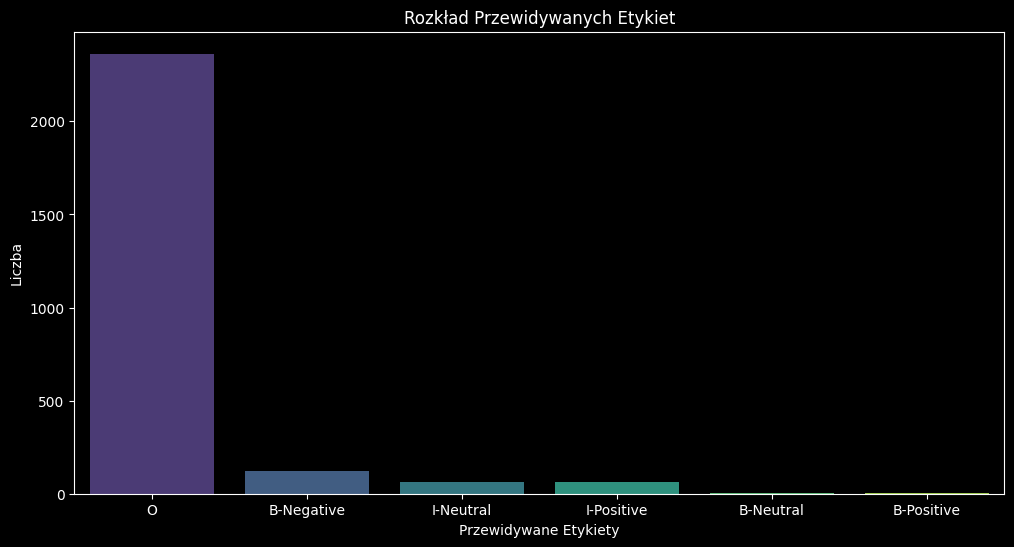

In [29]:
pred_label_counts = pd.Series(predicted_labels).value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values, hue=pred_label_counts.index, palette='viridis')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Liczba')
plt.title('Rozkład Przewidywanych Etykiet')
plt.show()

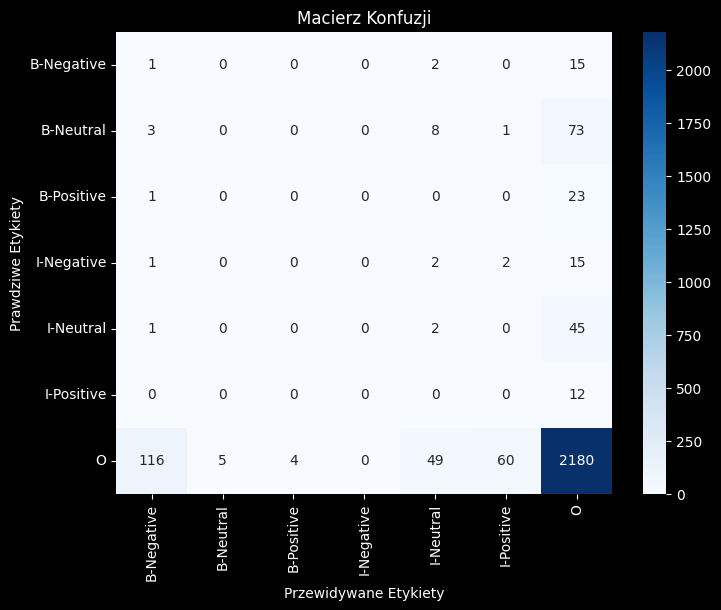

In [ ]:
sorted_labels = sorted(label_list)

cm = confusion_matrix(true_labels, predicted_labels, labels=sorted_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted_labels, yticklabels=sorted_labels, cmap='Blues')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Prawdziwe Etykiety')
plt.title('Macierz Konfuzji')
plt.show()

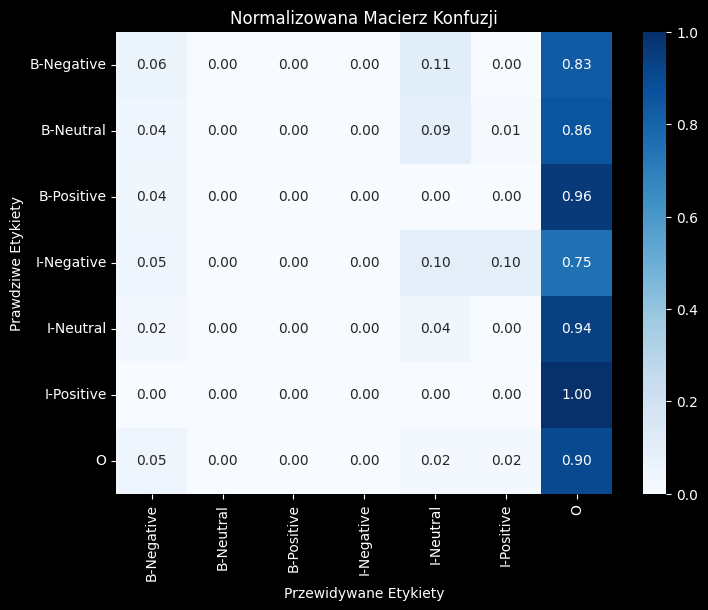

In [22]:
cm_normalized = confusion_matrix(true_labels, predicted_labels, labels=sorted_labels, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=sorted_labels, yticklabels=sorted_labels, cmap='Blues')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Prawdziwe Etykiety')
plt.title('Normalizowana Macierz Konfuzji')
plt.show()

In [23]:
report = classification_report(true_labels, predicted_labels, target_names=sorted_labels)
print(report)


              precision    recall  f1-score   support

  B-Negative       0.01      0.06      0.01        18
   B-Neutral       0.00      0.00      0.00        85
  B-Positive       0.00      0.00      0.00        24
  I-Negative       0.00      0.00      0.00        20
   I-Neutral       0.03      0.04      0.04        48
  I-Positive       0.00      0.00      0.00        12
           O       0.92      0.90      0.91      2414

    accuracy                           0.83      2621
   macro avg       0.14      0.14      0.14      2621
weighted avg       0.85      0.83      0.84      2621



/opt/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

